In [1]:

import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [2]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 100

In [3]:
# if not os.path.exists('train'):
#     !curl -L "https://public.roboflow.com/ds/xKLV14HbTF?key=aJzo7msVta" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    
#     dirs = ['train', 'valid', 'test']

#     for i, dir_name in enumerate(dirs):
#         all_image_names = sorted(os.listdir(f"{dir_name}/images/"))
#         for j, image_name in enumerate(all_image_names):
#             if (j % 2) == 0:
#                 file_name = image_name.split('.jpg')[0]
#                 os.remove(f"{dir_name}/images/{image_name}")
#                 os.remove(f"{dir_name}/labels/{file_name}.txt")

In [4]:
%cd /kaggle/input/new-dataset

/kaggle/input/new-dataset


In [5]:
#!pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="CDAIpD4xWAsVLrilNgn9")
# project = rf.workspace("ambition").project("wheelchair-woaim")
# dataset = project.version(2).download("yolov5")

In [6]:
#%cd /kaggle/input/dataset/Multi_Class_object_detection

In [7]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
    else: 
        print('File already present, skipping download...')

In [8]:
class_names = ['Animal', 'Cart', 'Debris', 'Dent', 'Graffiti', 'StreetLight', 'Streetsign', 'Tree','Water']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [9]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [10]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [11]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

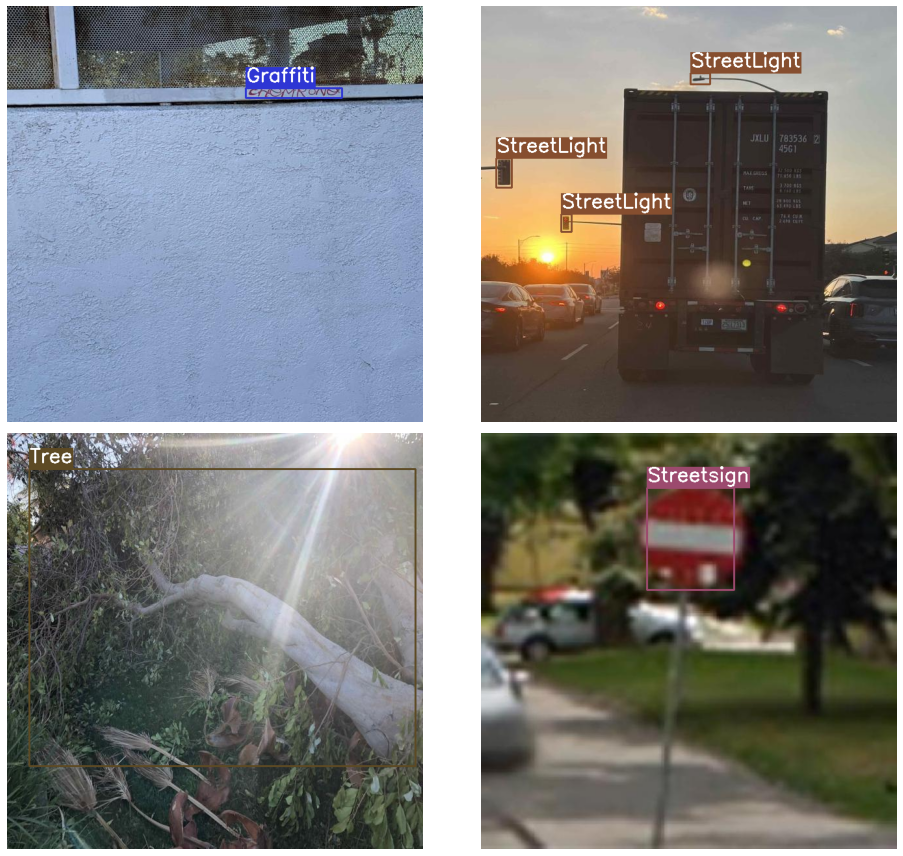

In [12]:
# Visualize a few training images.
plot(
    image_paths='train/images/*', 
    label_paths='train/labels/*',
    num_samples=4,
)

In [13]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [14]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

In [15]:
%cd /kaggle/working/

/kaggle/working


In [16]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 14858, done.
remote: Total 14858 (delta 0), reused 0 (delta 0), pack-reused 14858
Receiving objects: 100% (14858/14858), 13.90 MiB | 19.08 MiB/s, done.
Resolving deltas: 100% (10231/10231), done.


In [17]:
%cd yolov5/
!pwd

/kaggle/working/yolov5
/kaggle/working/yolov5


In [18]:
!pip install -r requirements.txt

In [19]:
monitor_tensorboard()

In [20]:
!cp -r /kaggle/input/new-dataset/train /kaggle/working/yolov5

In [21]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data /kaggle/input/new-dataset/data.yaml --weights yolov5l.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 0
results_1
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5l.pt, cfg=, data=/kaggle/input/new-dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-46-g96a71b1 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P10

In [22]:
%cd /kaggle/working/

/kaggle/working


In [23]:
!ls

__notebook__.ipynb  yolov5
